# 프로젝트 : 주식 예측에 도전해보자 해보자 

우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해보겠습니다.

In [ ]:
import pandas
import sklearn
import statsmodels

# Step1 : 시계열 데이터준비
데이터에는 날짜별로 시작가,최고가,최저가,종가,수정종가,거래량등이 저장되어있는 것을 확인할 수 있습니다.
여기서는 종가(Close)만 사용하겠습니다. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/익스플러레이션 데이터 - 아이펠 /삼성전자주가.csv', index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-07-22    79700.0
2021-07-23    79300.0
2021-07-26    78800.0
2021-07-27    78500.0
2021-07-28    79200.0
Name: Close, dtype: float64

In [ ]:
type(ts)

pandas.core.series.Series

# Step2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [ ]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치는 없는것 같습니다.

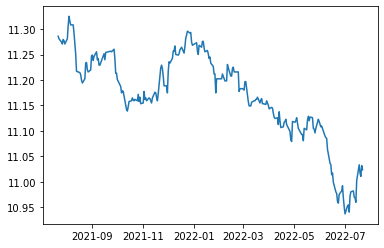

In [ ]:
# 시간 추이에따른 분산 제거
ts_log = np.log(ts)
plt.plot(ts_log)

# Step3 : 시계열 안정성 분석
1. 정성적 그래프 분석

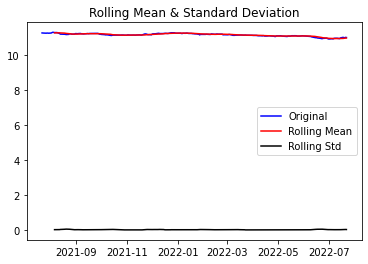

In [ ]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()  

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

2. 정량적 Augmented Dicky-Fuller Test (ADF test)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')  

    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey-Fuller Test:
Test Statistic                  -1.015654
p-value                          0.747512
#Lags Used                       0.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


3. 시계열분해

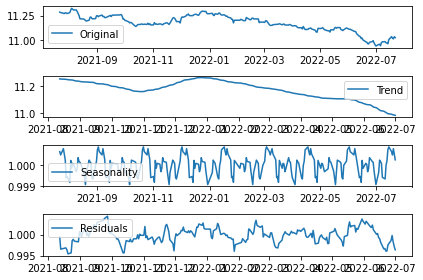

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

4. Residual 안정성 확인

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.854333
p-value                          0.000043
#Lags Used                       1.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


p-value가 많이 낮아졌기때문에 안정성이 있다고 볼수있습니다.

# Step 4: 학습, 테스트 데이터셋 생성

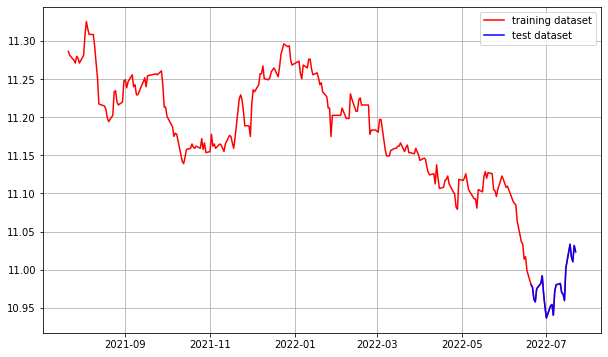

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# Step5 : 적정 ARIMA 모수 찾기

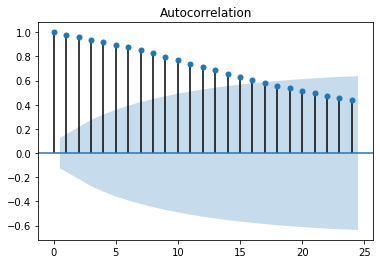

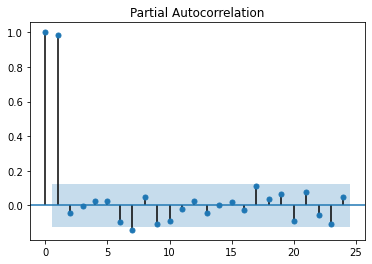

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF그래프는 지속적으로 천천히감소하는 패턴을 보이고 ,PACF그래프는 시차1이후에는 거의 0에 수렴하기때문에 이는 AR모델에 유사한형태를 보이고있습니다. 따라서 p=1, q=0으로 모수를 설정하겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.435210e+01
p-value                        1.017679e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


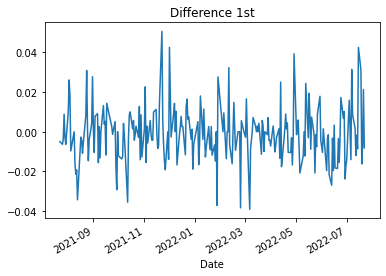

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.174247e+00
p-value                        2.343365e-15
#Lags Used                     8.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


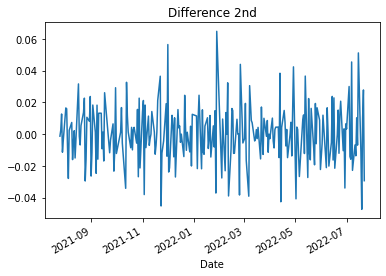

In [ ]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분을 구하니 p-value가 올라갔기때문에 차분은 1차를 사용하도록하겠습니다.

# Step6 : ARIMA 모델 훈련과 테스트 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  219
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 637.823
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 27 Jul 2022   AIC                          -1269.646
Time:                        00:12:40   BIC                          -1259.479
Sample:                             1   HQIC                         -1265.540
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0013      0.001     -1.385      0.168      -0.003       0.001
ar.L1.D.Close     0.0670      0.068      0.992      0.322      -0.065       0.199
                                    Root

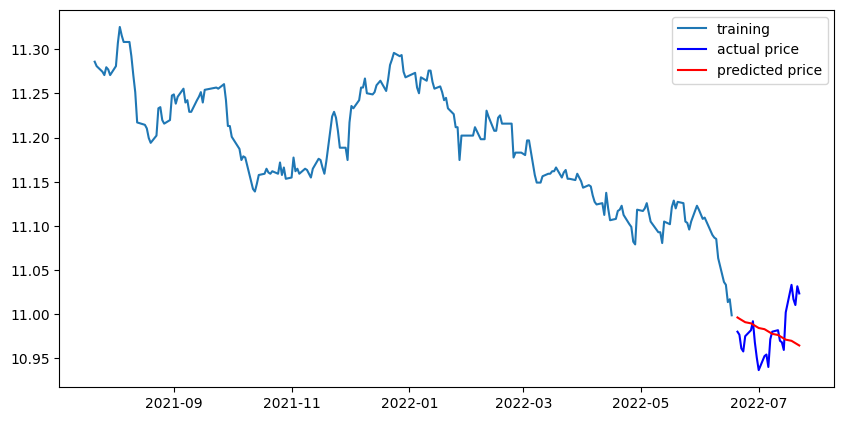

In [ ]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc[0], index=test_data.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc[0]))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc[0])) 
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc[0])))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc[0]) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3845956.334284667
MAE:  1594.6691110041088
RMSE:  1961.1109948915862
MAPE: 2.70%


# Step7 : 다른 주식 종목 예측해보기

# UnitySoftware

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/익스플러레이션 데이터 - 아이펠 /U.csv', index_col='Date', parse_dates=True)
ts2 = df2['Close']
ts2.head()

Date
2021-07-26    103.320000
2021-07-27    100.779999
2021-07-28    108.750000
2021-07-29    111.250000
2021-07-30    107.120003
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


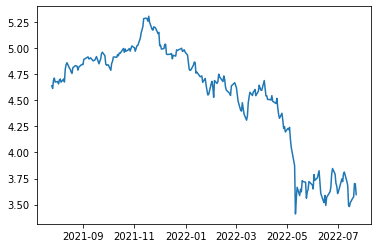

In [ ]:
# 결측치 제거, 로그변환
print(ts[ts.isna()])
ts_log2 = np.log(ts2)
plt.plot(ts_log2)

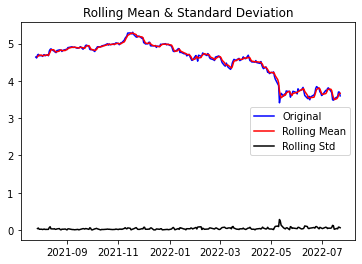

Results of Dickey-Fuller Test:
Test Statistic                  -0.057980
p-value                          0.953466
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


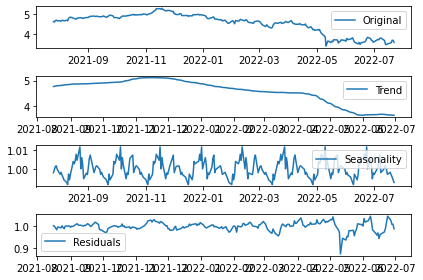

In [ ]:
# 시계열 안정성 분석

# 1.정성적 그래프 분석
plot_rolling_statistics(ts_log2, window=3)

# 2.정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log2)

# 3.시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log2, model='multiplicative', freq = 30) 

trend2 = decomposition.trend
seasonal2 = decomposition.seasonal
residual2 = decomposition.resid

plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual 안정성 확인
residual2.dropna(inplace=True)
print(augmented_dickey_fuller_test(residual2))

Results of Dickey-Fuller Test:
Test Statistic                  -5.119537
p-value                          0.000013
#Lags Used                      14.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
None


p-value가 많이 낮아졌기때문에 안정성이 있다고 볼 수 있습니다.

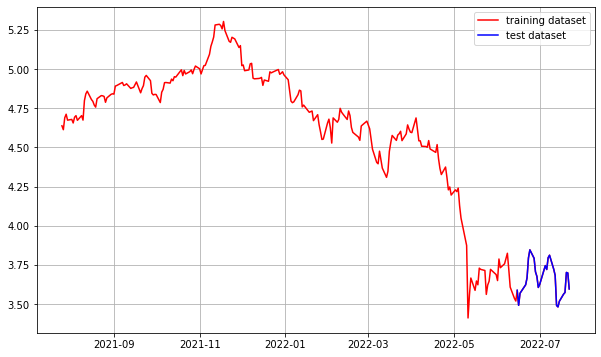

In [ ]:
# 학습, 테스트 데이터 생성
train_data2, test_data2 = ts_log2[:int(len(ts_log2)*0.9)], ts_log2[int(len(ts_log2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()

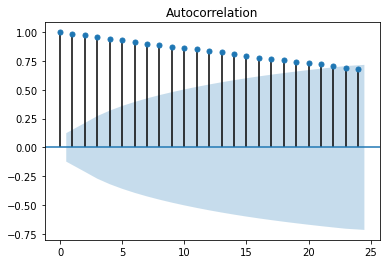

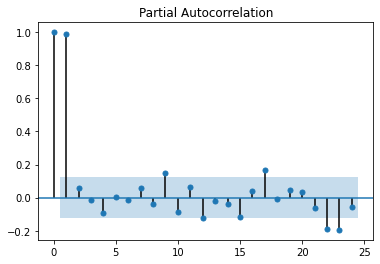

In [ ]:
# 적정 ARIMA 모수 찾기

plot_acf(ts_log2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 지속적으로 천천히 감소하는 형태이고, PACF는 시차1이후에 거의 0이기때문에 이는 AR모델의 형태에 가깝다고볼 수 있습니다. 따라서 p=1, q=0으로 모수를 설정하겠습니다. 하지만 모델을 돌려보고 성능잘 나오지 않는다면 p=22,23도 한번 사용해보겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.435210e+01
p-value                        1.017679e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


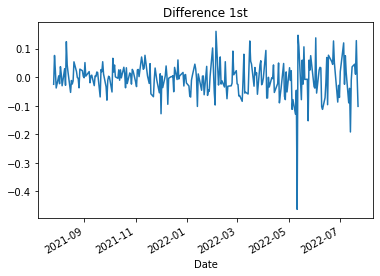

In [ ]:
# 1차 차분 구하기
diff_1_2 = ts_log2.diff(periods=1).iloc[1:]
diff_1_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.995747e+00
p-value                        2.406960e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


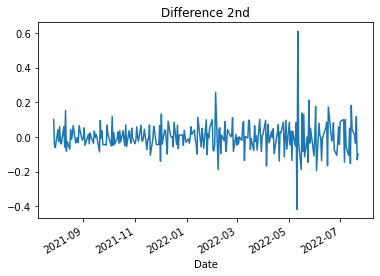

In [ ]:
# 2차 차분 구하기
diff_2_2 = diff_1_2.diff(periods=1).iloc[1:]
diff_2_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_2)

차분은 1차차분에서 p-value가 더 낮기때문에 차분은 1차로 하겠습니다.

In [ ]:
# ARIMA 모델훈련 및 테스트

model2 = ARIMA(train_data2, order=(23, 1, 0))  
fitted_m2 = model2.fit() 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


여기서 p=1를 사용했었지만 성능이 잘 나오지않아 23을 사용하였다.

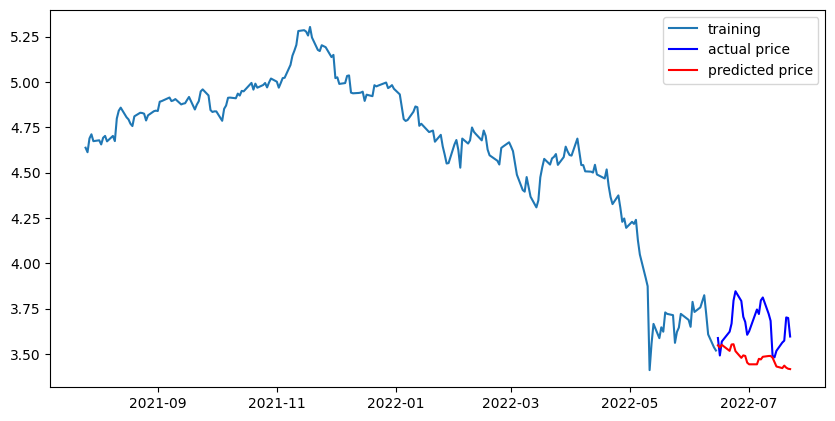

In [ ]:
fc2 = fitted_m2.forecast(len(test_data2), alpha=0.05)

fc_series2 = pd.Series(fc2[0], index=test_data2.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(np.exp(test_data2), np.exp(fc2[0]))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data2), np.exp(fc2[0])) 
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2[0])))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc2[0]) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  59.0649990502422
MAE:  6.607263857646432
RMSE:  7.68537566097079
MAPE: 16.15%


# Coupang

In [ ]:
# 데이터 불러오기
df3 = pd.read_csv('/content/drive/MyDrive/익스플러레이션 데이터 - 아이펠 /CPNG.csv', index_col='Date', parse_dates=True)
ts3 = df3['Close']
ts3.head()

Date
2021-07-26    37.189999
2021-07-27    37.540001
2021-07-28    38.389999
2021-07-29    37.570000
2021-07-30    36.320000
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


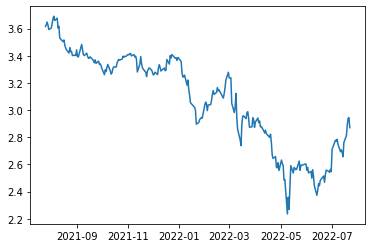

In [ ]:
# 결측치 제거, 로그변환
print(ts3[ts3.isna()])
ts_log3 = np.log(ts3)
plt.plot(ts_log3)

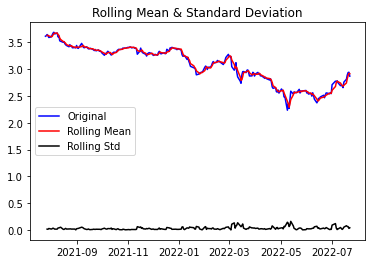

Results of Dickey-Fuller Test:
Test Statistic                  -1.573344
p-value                          0.496968
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


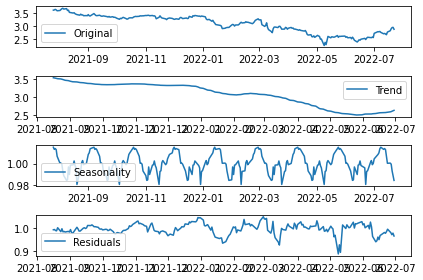

In [ ]:
# 시계열 안정성 분석

# 1.정성적 그래프 분석
plot_rolling_statistics(ts_log3, window=3)

# 2.정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log3)

# 3.시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log3, model='multiplicative', freq = 30) 

trend3 = decomposition.trend
seasonal3 = decomposition.seasonal
residual3 = decomposition.resid

plt.subplot(411)
plt.plot(ts_log3, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend3, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal3,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual3, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual 안정성 확인
residual3.dropna(inplace=True)
print(augmented_dickey_fuller_test(residual3))

Results of Dickey-Fuller Test:
Test Statistic                  -4.967427
p-value                          0.000026
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64
None


p-value가 많이 낮아져 안정성이 있다고 볼 수 있습니다.

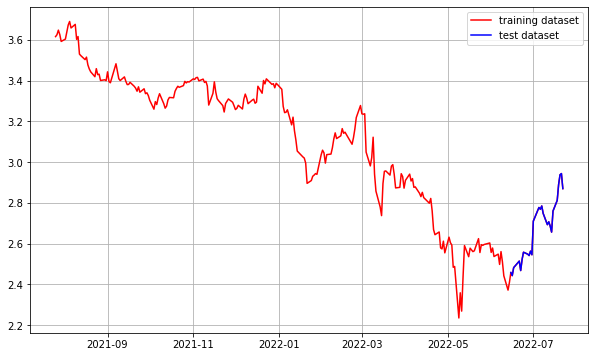

In [ ]:
# 학습, 테스트 데이터 생성
train_data3, test_data3 = ts_log3[:int(len(ts_log3)*0.9)], ts_log3[int(len(ts_log3)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log3, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data3, c='b', label='test dataset')
plt.legend()

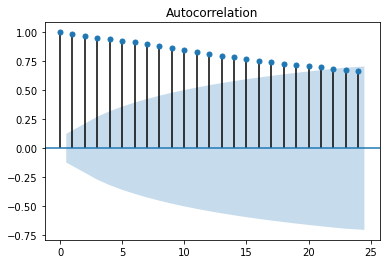

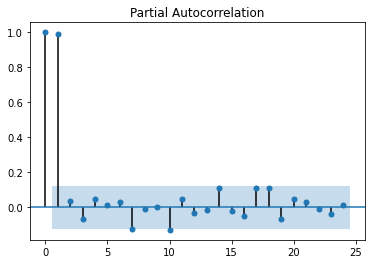

In [ ]:
# 적정 ARIMA 모수 찾기

plot_acf(ts_log3)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log3)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF의 값이 점진적으로 천천히 낮아지고, PACF에서 시차가 p=1이후로 0에 수렴하기때문에, 이는 AR모델의 형태에 가깝다고 볼 수 있습니다. 따라서 p=1, q=0을 모수로 설정하겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.630555e+01
p-value                        3.234226e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


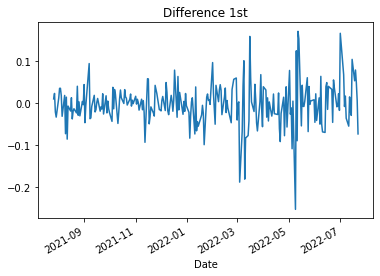

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log3.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.247586e+00
p-value                        1.522619e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


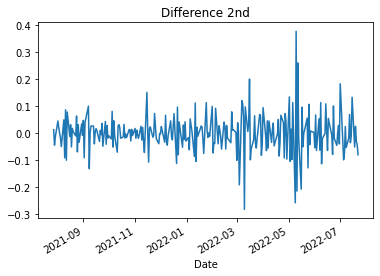

In [ ]:
# 2차 차분 구하기
diff_2_2 = diff_1.diff(periods=1).iloc[1:]
diff_2_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_2)

1차 차분의 p-value가 더 낮기때문에 차분은 1차로 하겠습니다.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


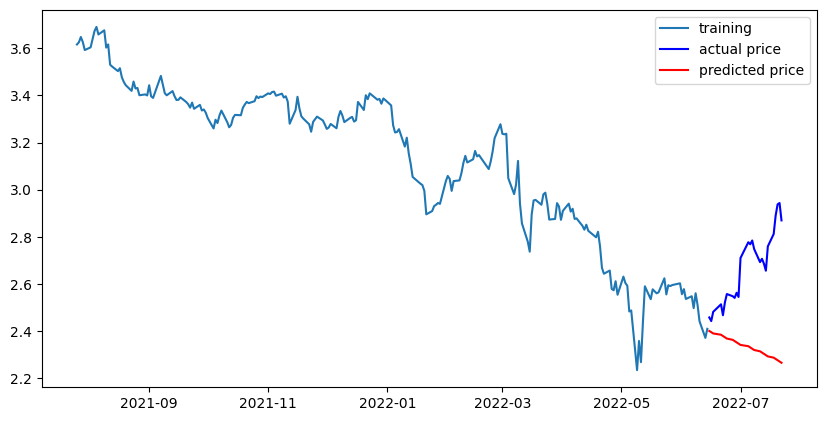

In [ ]:
# ARIMA 모델훈련 및 테스트

model2 = ARIMA(train_data3, order=(1, 1, 0))  
fitted_m2 = model2.fit()
fc3 = fitted_m2.forecast(len(test_data3), alpha=0.05)

fc_series3 = pd.Series(fc3[0], index=test_data3.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data3, label='training')
plt.plot(test_data3, c='b', label='actual price')
plt.plot(fc_series3, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(np.exp(test_data3), np.exp(fc3[0]))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data3), np.exp(fc3[0])) 
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data3), np.exp(fc3[0])))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc3[0]) - np.exp(test_data3))/np.abs(np.exp(test_data3)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  25.087774417669515
MAE:  4.2661042439130075
RMSE:  5.008769750913842
MAPE: 27.19%


# 회고
이번 exploration에서는 시계열 데이터의 특성과 안정성에대해 공부했고, ARIMA모델을 사용해서 실제 주식의 주가를 예측해보았다. 이번에 이 ARIMA모델에 대해서 공부한다고 정말 머리가 많이 아팠다. 처음에 노드를 여러번 읽어도 이해가가지않았고, 구글링을 몇일을 해보고 나서 다시 노드를 또 읽었을때 어느정도 이해가 가게되었다. 물론 100%로는 아니지만 전반적인 개념에대해서는 숙지하게되었다. 하지만 특히 ARIMA모델의 모수설정하는게 이론적인 이해는 어느정도했지만 실제 데이터를 적용해보면 성능이 만족스럽게 나오지않았다. 특히 마지막 coupang주식에 적용했을때 분명 충분히 시계열은 안정성을 보였고 PACF와 ACF에서 AR모델형태를 보였고 p=1 이후에 0에 수렴했기에 p=1, q=0, d=1을 적용해 예측해보았다. 하지만 결과는 MAPE가 27%로 사실상 거의 예측을 못했다고 볼 수 있다. 내 생각엔 훈련데이터와 테스트데이터가 나뉘는 시점에서 문제가 생긴것같다. 그 시점을 살펴보면, 테스트 데이터에서 갑자기 주가가 급등하는 것을 볼 수 있다. 이에 반해 훈련 데이터는 지속적으로 감소하고 있다. 때문에 모델이 예측에 실패했지않을까하는 생각이다. 따라서 시계열이 안정성을 보이고 적당한 모수를 사용해도 상황에따라서 예측을 할 수 없는 데이터도 존재하는것 같다.